# Panel - Low/High Mortality Bridges (Edges)

This notebook mirrors the analysis in `009_panel_outlier_counts.ipynb`,
but applied to **all bridge edges** from `bridge_edges_mortality_ZSCORE.csv`.

Outputs are saved as PNG/PDF at 600 dpi.

Set `TAPAS_OUTPUT_DIR` / `TAPAS_DATA_DIR` if your paths differ.


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from matplotlib.lines import Line2D

# OUTPUT_DIR = Path(os.getenv('TAPAS_OUTPUT_DIR', '../../outputs'))
# FIG_DIR = OUTPUT_DIR / 'figures'
# FIG_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path('./../../figures/')


# FIG_DIR = Path('./../../figures/')

plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 8, 'axes.titlesize': 8, 'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8})
# Figure sizes to match 009 style
SMALL_FIG = (2.08, 0.96)
BAR_FIG = (6.6, 3.4)
ALLUVIAL_FIG = (2.00, 2.20)
STREAM_FIG = (7.2, 3.6)
HEATMAP_FIG = (4.8, 4.0)
LEGEND_FIG = (2.8, 1.76)

def save_figure(fig, name_base):
    png_path = FIG_DIR / f"{name_base}.png"
    pdf_path = FIG_DIR / f"{name_base}.pdf"
    fig.savefig(png_path, dpi=600, bbox_inches='tight', transparent=True)
    fig.savefig(pdf_path, dpi=600, bbox_inches='tight', transparent=True)
    print(f"Saved: {png_path}")
    print(f"Saved: {pdf_path}")


In [4]:
DATA_DIR = Path(os.getenv('TAPAS_DATA_DIR', '../../Data'))
BRIDGE_PATH = DATA_DIR / 'bridge_edges_mortality_ZSCORE.csv'
OUTLIERS_PATH = DATA_DIR / 'high_mortality_sinks_ZSCORE.csv'

if not BRIDGE_PATH.exists():
    raise FileNotFoundError(f"Missing {BRIDGE_PATH}. Put bridge_edges_mortality_ZSCORE.csv in DATA_DIR.")

df_bridge = pd.read_csv(BRIDGE_PATH)



# Normalize column names
col_map = {c.lower(): c for c in df_bridge.columns}
sex_col = col_map.get('sex') or col_map.get('gender') or col_map.get('Sex')
age_col = col_map.get('age_group') or col_map.get('Age_Group')

if sex_col is None or age_col is None:
    raise ValueError('Expected columns for sex and age_group in bridge_edges_mortality_ZSCORE.csv')

# Use all edges
df_edges = df_bridge.copy()

# Convert age group like 'age_1' -> 1 if needed
if df_edges[age_col].dtype == object:
    df_edges['age_num'] = df_edges[age_col].astype(str).str.replace('age_', '', regex=False).astype(int)
else:
    df_edges['age_num'] = df_edges[age_col].astype(int)

# Keep only age groups from the first low-high bridge group onward
min_age_num = 5
df_edges = df_edges[df_edges['age_num'] >= min_age_num].copy()

# Chapter colors must match 009 (high_mortality_sinks_ZSCORE.csv)
hex_colors = [
  '#1AF239',  # (26, 242, 57) A
  '#58F21A',  # (88, 242, 26) B
  '#961D1A',  # (150, 29, 26) C
  '#B41AF2',  # (180, 26, 242) D
  '#FFC801',  # (255, 202, 1) E
  '#581AF2',  # (88, 26, 242) F
  '#1AF295',  # (26, 242, 149) G
  '#1A95F2',  # (26, 149, 242) H
  '#F2761A',  # (242, 118, 26) I
  '#1A39F2',  # (26, 57, 242) J
  '#F21A1A',  # (242, 26, 26) K
  '#F21AD3',  # (242, 26, 211) L
  '#B4F21A',  # (180, 242, 26) M
  '#1AF2F2',  # (26, 242, 242) N
]
palette = hex_colors
chapter_color_map = dict(zip(list('ABCDEFGHIJKLMN'), palette))
if OUTLIERS_PATH.exists():
    df_outliers = pd.read_csv(OUTLIERS_PATH)
    if 'ICD_Code' in df_outliers.columns:
        outlier_chapters = df_outliers['ICD_Code'].astype(str).str[0]
        unique_chapters = sorted(outlier_chapters.unique())
    else:
        unique_chapters = sorted(pd.unique(pd.concat([df_edges['ICD_Code_1'].astype(str).str[0], df_edges['ICD_Code_2'].astype(str).str[0]])))
else:
    unique_chapters = sorted(pd.unique(pd.concat([df_edges['ICD_Code_1'].astype(str).str[0], df_edges['ICD_Code_2'].astype(str).str[0]])))
chapter_colors = {ch: chapter_color_map.get(ch, '#CCCCCC') for ch in unique_chapters}

df_edges.head()


,Sex,Age_Group,ICD_Code_1,ICD_Code_2,Description_1,Description_2,Weight,Edge_Betweenness,Mortality_1,Mortality_2,Mortality_Diff,z_betweenness,z_mort_diff,z_product,Selection_Method,Description_Eng_1,Description_Eng_2,age_num
0,Female,6,C34,F17,Bösartige Neubildung der Bronchien und der Lunge,Psychische und Verhaltensstörungen durch Tabak...,6.808248,0.000145,0.333199,0.010039,0.323161,0.119751,7.172693,0.858936,Z-Score Product,Malignant neoplasm of bronchus and lung,Nicotine dependence,6
1,Female,6,C34,F32,Bösartige Neubildung der Bronchien und der Lunge,Depressive Episode,1.553406,0.000302,0.333199,0.005655,0.327545,0.992030,7.276939,7.218944,Z-Score Product,Malignant neoplasm of bronchus and lung,"Major depressive disorder, single episode",6
2,Female,6,C78,K29,Sekundäre bösartige Neubildung der Atmungs- un...,Gastritis und Duodenitis,1.512336,0.000882,0.311765,0.002840,0.308924,4.223504,6.834168,28.864131,Z-Score Product,Secondary malignant neoplasm of respiratory an...,Gastritis and duodenitis,6
3,Female,6,C78,N39,Sekundäre bösartige Neubildung der Atmungs- un...,Sonstige Krankheiten des Harnsystems,1.710156,0.000611,0.311765,0.007733,0.304032,2.715385,6.717823,18.241479,Z-Score Product,Secondary malignant neoplasm of respiratory an...,Other disorders of urinary system,6
4,Female,7,A41,I10,Sonstige Sepsis,"Essentielle (primäre) Hypertonie, Bluthochdruc...",2.647207,0.000214,0.331519,0.019394,0.312125,0.576563,5.111790,2.947268,Z-Score Product,Other sepsis,Essential (primary) hypertension,7


In [5]:
len(df_edges)

76

Saved: ..\..\figures\panel_bridge_edges_by_age_sex.png
Saved: ..\..\figures\panel_bridge_edges_by_age_sex.pdf


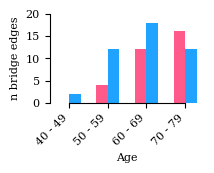

In [6]:
counts = (
    df_edges.groupby([sex_col, 'age_num'])
    .size()
    .reset_index(name='count')
)

# Update the plot with age group labels and remove top/right spines
fig, ax = plt.subplots(figsize=(2.00, 1.16))

# Pastel colors
colors = {'Male': '#1FA3FF', 'Female': '#FF5A8A'}

for sex, sub in counts.groupby(sex_col):
    color = colors.get(sex, '#CCCCCC')
    ax.bar(sub['age_num'] + (0.15 if str(sex).lower().startswith('m') else -0.15),
           sub['count'], width=0.3, label=str(sex), color=color)

age_labels_full = ['0 - 9', '10 - 19', '20 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79']
age_labels = age_labels_full[min_age_num - 1:]
age_ticks = np.arange(min_age_num, len(age_labels_full) + 1)
ax.set_xticks(age_ticks)
ax.set_xticklabels(age_labels, rotation=45, ha='right', fontsize=8)
ax.tick_params(axis='y', labelsize=8)

ax.set_xlabel('Age', fontsize=8)
ax.set_ylabel('n bridge edges', fontsize=8)
#ax.legend(frameon=False, fontsize=8, title_fontsize=8, loc='upper left', bbox_to_anchor=(0, 1.15))

ax.set_xlim(age_ticks.min() - 0.5, age_ticks.max() + 0.5)
ax.set_ylim(0, counts['count'].max() + 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(age_ticks.max(), age_ticks.min())
ax.spines['left'].set_bounds(counts['count'].max() + 2, 0)

save_figure(fig, 'panel_bridge_edges_by_age_sex')
plt.show()


Saved: ..\..\figures\panel_bridge_edges_by_age_chapter_pair.png
Saved: ..\..\figures\panel_bridge_edges_by_age_chapter_pair.pdf


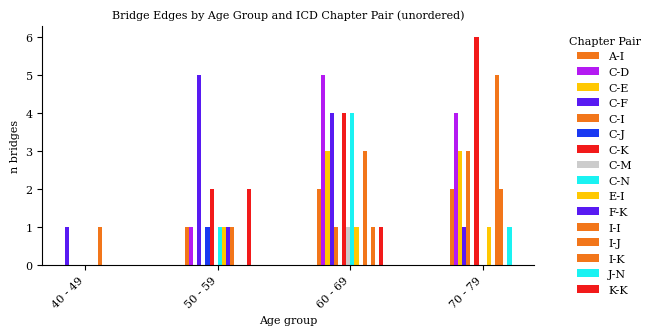

In [7]:
# Chapter pairs (unordered) by age group
# Extract ICD chapters for both ends of the edge
df_edges['ICD_Chapter_1'] = df_edges['ICD_Code_1'].astype(str).str[0]
df_edges['ICD_Chapter_2'] = df_edges['ICD_Code_2'].astype(str).str[0]

def lower_mort_chapter(r):
    m1 = r.get('Mortality_1')
    m2 = r.get('Mortality_2')
    if pd.isna(m1) and pd.isna(m2):
        return str(r['ICD_Chapter_1'])
    if pd.isna(m2) or (pd.notna(m1) and m1 <= m2):
        return str(r['ICD_Chapter_1'])
    return str(r['ICD_Chapter_2'])

df_edges['Lower_Mort_Chapter'] = df_edges.apply(lower_mort_chapter, axis=1)

# Unordered pair key
df_edges['Chapter_Pair'] = df_edges.apply(
    lambda r: '-'.join(sorted([str(r['ICD_Chapter_1']), str(r['ICD_Chapter_2'])])),
    axis=1
)

pair_counts = (
    df_edges.groupby(['age_num', 'Chapter_Pair'])
    .size()
    .reset_index(name='count')
)

ages = sorted(pair_counts['age_num'].unique())
pairs = sorted(pair_counts['Chapter_Pair'].unique())

pair_to_low_chapter = (
    df_edges.groupby('Chapter_Pair')['Lower_Mort_Chapter']
    .agg(lambda s: s.value_counts().idxmax())
    .to_dict()
)
pair_colors = {p: chapter_colors.get(pair_to_low_chapter.get(p, ''), '#CCCCCC') for p in pairs}

# Bar plot: chapter-pair counts by age (stacked style using offsets)
fig, ax = plt.subplots(figsize=BAR_FIG)

n_pairs = len(pairs)
bar_width = 0.8 / max(n_pairs, 1)
offsets = np.linspace(-0.4 + bar_width / 2, 0.4 - bar_width / 2, max(n_pairs, 1))

age_ticks = np.array(sorted(df_edges['age_num'].unique()))
group_spacing = 1.6
age_positions = age_ticks * group_spacing
pos_map = dict(zip(age_ticks, age_positions))

for idx, pair in enumerate(pairs):
    subset = pair_counts[pair_counts['Chapter_Pair'] == pair]
    x = subset['age_num'].map(pos_map)
    ax.bar(x + offsets[idx], subset['count'],
           width=bar_width, label=pair, color=pair_colors[pair])

ax.set_xticks(age_positions)
ax.set_xticklabels([age_labels_full[a - 1] for a in age_ticks], rotation=45, ha='right')
ax.set_xlabel('Age group')
ax.set_ylabel('n bridges')
ax.set_title('Bridge Edges by Age Group and ICD Chapter Pair (unordered)')
ax.legend(title='Chapter Pair', frameon=False, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
save_figure(fig, 'panel_bridge_edges_by_age_chapter_pair')
plt.show()


Saved: ..\..\figures\panel_bridge_edges_alluvial_by_age_chapter_pair.png
Saved: ..\..\figures\panel_bridge_edges_alluvial_by_age_chapter_pair.pdf


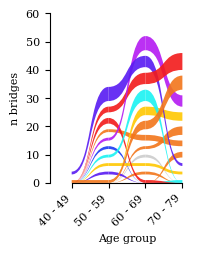

In [8]:
# Alluvial-style ribbons by age group (color = lower-mortality ICD chapter, thickness = count)
counts = pair_counts.copy()

age_ticks = np.array(sorted(df_edges['age_num'].unique()))
ages = list(age_ticks)
pairs = sorted(counts['Chapter_Pair'].unique())

pair_to_low_chapter = (
    df_edges.groupby('Chapter_Pair')['Lower_Mort_Chapter']
    .agg(lambda s: s.value_counts().idxmax())
    .to_dict()
)
pair_colors = {p: chapter_colors.get(pair_to_low_chapter.get(p, ''), '#CCCCCC') for p in pairs}

wide = (counts
        .pivot(index='age_num', columns='Chapter_Pair', values='count')
        .reindex(index=ages, columns=pairs)
        .fillna(0.0))

group_spacing = 1.6
x = np.arange(len(ages)) * group_spacing

age_label_map = {a: age_labels_full[a - 1] for a in ages}

gap = 2.0
curviness = 0.55
alpha = 0.90
min_height = 0.0

y0 = {a: {} for a in ages}
y1 = {a: {} for a in ages}
column_heights = {}

for a in ages:
    row = wide.loc[a].to_dict()
    ordered = sorted(pairs, key=lambda ch: row[ch], reverse=True)
    cum = 0.0
    nonzero = 0
    for ch in ordered[::-1]:
        h = float(row[ch])
        if h <= 0:
            y0[a][ch] = cum
            y1[a][ch] = cum
            continue
        y0[a][ch] = cum
        y1[a][ch] = cum + h
        cum += h
        nonzero += 1
        cum += gap
    if nonzero > 0:
        cum -= gap
    column_heights[a] = cum

max_height = max(column_heights.values()) if column_heights else 1.0

def ribbon_path(x0, b0, t0, x1, b1, t1, bend=0.55):
    dx = x1 - x0
    cdx = dx * bend
    codes = [
        MplPath.MOVETO,
        MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4,
        MplPath.LINETO,
        MplPath.CURVE4, MplPath.CURVE4, MplPath.CURVE4,
        MplPath.CLOSEPOLY
    ]
    verts = [
        (x0, t0),
        (x0 + cdx, t0),
        (x1 - cdx, t1),
        (x1, t1),
        (x1, b1),
        (x1 - cdx, b1),
        (x0 + cdx, b0),
        (x0, b0),
        (x0, t0)
    ]
    return MplPath(verts, codes)

fig, ax = plt.subplots(figsize=ALLUVIAL_FIG)
ribbons = []
for i in range(len(ages) - 1):
    a0, a1 = ages[i], ages[i + 1]
    x0, x1 = x[i], x[i + 1]
    for ch in pairs:
        h0 = y1[a0][ch] - y0[a0][ch]
        h1 = y1[a1][ch] - y0[a1][ch]
        if max(h0, h1) <= min_height:
            continue
        path = ribbon_path(x0, y0[a0][ch], y1[a0][ch], x1, y0[a1][ch], y1[a1][ch], bend=curviness)
        ribbons.append((max(h0, h1), ch, path))

ribbons.sort(key=lambda t: t[0])
for _, ch, path in ribbons:
    ax.add_patch(PathPatch(path, facecolor=pair_colors[ch], edgecolor='none', alpha=alpha))

ax.set_xlim(x.min() - group_spacing * 0.6, x.max() + group_spacing * 0.6)
ax.set_ylim(0, 60)

ax.set_xticks(x)
ax.set_xticklabels([age_label_map[a] for a in ages], rotation=45, ha='right')

ax.set_xlabel('Age group')
ax.set_ylabel('n bridges')
# ax.set_title('Alluvial ribbons by age group (color=ICD chapter, thickness=count)')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(x.max(), x.min())
ax.spines['left'].set_bounds(60, 0)


handles = [Line2D([0], [0], color=pair_colors[ch], lw=8) for ch in pairs]
# ax.legend(handles, pairs, title='Chapter Pair', frameon=False, bbox_to_anchor=(1.02, 1), loc='upper left')

save_figure(fig, 'panel_bridge_edges_alluvial_by_age_chapter_pair')
plt.show()


Saved: ..\..\figures\panel_bridge_edges_by_age_heatmap_short_icd_edges.png
Saved: ..\..\figures\panel_bridge_edges_by_age_heatmap_short_icd_edges.pdf


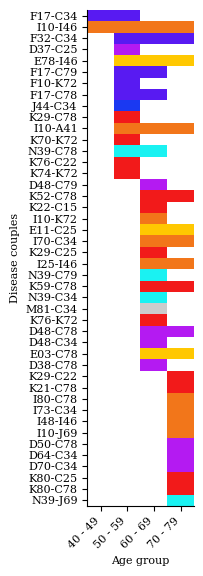

In [9]:
# Heatmap: edges by age (colored by lower-mortality ICD chapter; same colors as 009)
# Y-axis shows full edge labels (ICD short codes).

def short_icd(icd):
    if not icd or pd.isna(icd):
        return 'NA'
    return str(icd).split('.', 1)[0]

# Ensure chapter pair columns exist
if 'ICD_Chapter_1' not in df_edges.columns:
    df_edges['ICD_Chapter_1'] = df_edges['ICD_Code_1'].astype(str).str[0]
if 'ICD_Chapter_2' not in df_edges.columns:
    df_edges['ICD_Chapter_2'] = df_edges['ICD_Code_2'].astype(str).str[0]
if 'Chapter_Pair' not in df_edges.columns:
    df_edges['Chapter_Pair'] = df_edges.apply(
        lambda r: '-'.join(sorted([str(r['ICD_Chapter_2']), str(r['ICD_Chapter_1'])])),
        axis=1
    )

# Ensure lower-mortality chapter exists
if 'Lower_Mort_Chapter' not in df_edges.columns:
    def lower_mort_chapter(r):
        m1 = r.get('Mortality_1')
        m2 = r.get('Mortality_2')
        if pd.isna(m1) and pd.isna(m2):
            return str(r['ICD_Chapter_1'])
        if pd.isna(m2) or (pd.notna(m1) and m1 >= m2):
            return str(r['ICD_Chapter_1'])
        return str(r['ICD_Chapter_2'])
    df_edges['Lower_Mort_Chapter'] = df_edges.apply(lower_mort_chapter, axis=1)

# Build edge labels (low-to-high mortality, short ICD codes)
df_tmp = df_edges.copy()
df_tmp['icd1_short'] = df_tmp['ICD_Code_1'].map(short_icd)
df_tmp['icd2_short'] = df_tmp['ICD_Code_2'].map(short_icd)
def edge_label_low_high(r):
    m1 = r.get('Mortality_1')
    m2 = r.get('Mortality_2')
    i1 = str(r['icd1_short'])
    i2 = str(r['icd2_short'])
    if pd.isna(m1) and pd.isna(m2):
        return '-'.join(sorted([i1, i2]))
    if pd.isna(m2) or (pd.notna(m1) and m1 <= m2):
        return f"{i1}-{i2}"
    return f"{i2}-{i1}"

df_tmp['Edge_Label'] = df_tmp.apply(edge_label_low_high, axis=1)

# Map edge -> lower-mortality chapter for row colors
edge_to_low_chapter = (
    df_tmp.drop_duplicates('Edge_Label')
          .set_index('Edge_Label')['Lower_Mort_Chapter']
          .to_dict()
)

# Edge-by-age counts
heatmap_data = (
    df_tmp.groupby(['Edge_Label', 'age_num'])
    .size()
    .unstack(fill_value=0)
)

# Force full age axis (min_age_num..8) to align with labels
age_ticks = np.array(sorted(df_edges['age_num'].unique()))
heatmap_data = heatmap_data.reindex(columns=age_ticks, fill_value=0)

# Order edges by first age group they appear in
present = heatmap_data.values > 0
first_age_present = present.argmax(axis=1)
first_age_present[~present.any(axis=1)] = heatmap_data.shape[1]
sorted_idx = np.argsort(first_age_present)
heatmap_data_sorted = heatmap_data.iloc[sorted_idx]
edge_labels = heatmap_data_sorted.index.tolist()
n_edges, n_ages = heatmap_data_sorted.shape

present = heatmap_data_sorted.values > 0
color_idx = np.tile(np.arange(n_edges)[:, None], (1, n_ages))
masked_idx = np.ma.masked_where(~present, color_idx)

row_colors = [chapter_colors.get(edge_to_low_chapter.get(lbl, ''), '#CCCCCC') for lbl in edge_labels]
cmap = plt.matplotlib.colors.ListedColormap(row_colors)
cmap.set_bad(color='white')

fig_edge, ax_edge = plt.subplots(figsize=(2.08, 5.8))
im = ax_edge.imshow(masked_idx, aspect='auto', cmap=cmap, interpolation='none',
                    vmin=0, vmax=n_edges - 1)

ax_edge.set_xticks(range(n_ages))
ax_edge.set_xticklabels([age_labels_full[a - 1] for a in age_ticks], rotation=45, ha='right')
ax_edge.set_yticks(range(n_edges))
ax_edge.set_yticklabels(edge_labels, fontsize=8)
ax_edge.set_xlabel('Age group')
ax_edge.set_ylabel('Disease couples')

ax_edge.spines['top'].set_visible(False)
ax_edge.spines['right'].set_visible(False)

fig_edge.tight_layout()
save_figure(fig_edge, 'panel_bridge_edges_by_age_heatmap_short_icd_edges')
plt.show()


Saved: ..\..\figures\legend_bridge_edges_heatmap_chapter_pair.png
Saved: ..\..\figures\legend_bridge_edges_heatmap_chapter_pair.pdf


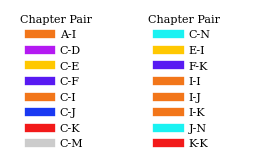

In [10]:
# Legend-only figure for the heatmap (Chapter pairs) - two separate columns
fig, ax = plt.subplots(figsize=LEGEND_FIG)
ax.axis('off')

legend_handles = [plt.Line2D([0], [0], color=pair_colors[p], lw=6) for p in pairs]
legend_labels = pairs

mid = (len(legend_handles) + 1) // 2
h1, l1 = legend_handles[:mid], legend_labels[:mid]
h2, l2 = legend_handles[mid:], legend_labels[mid:]

leg1 = ax.legend(h1, l1, title='Chapter Pair', frameon=False,
                 loc='center left', bbox_to_anchor=(0.0, 0.5))
ax.add_artist(leg1)
ax.legend(h2, l2, title='Chapter Pair', frameon=False,
          loc='center left', bbox_to_anchor=(0.5, 0.5))

fig.tight_layout()
save_figure(fig, 'legend_bridge_edges_heatmap_chapter_pair')
plt.show()
